# Analyzing TC genesis in aquaplanet simulations

In [1]:
from waveFilter import kf_filter
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats
from functions_mpas_aqua import find_tcgen,find_tcgen_closedcontour,find_nondev_analogs_to_devtcs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from IPython.display import display

#increase font size
plt.rcParams.update({'font.size': 18})

# #color-blind friendly colors
# colors = ['#377eb8', '#4daf4a',
#           '#f781bf', '#a65628', '#984ea3',
#           '#999999', '#e41a1c', '#dede00'] #source: https://gist.github.com/thriveth/8560036

Define basic information that will be used to access files, filter waves, etc.

In [2]:
exp_name = 'TC_3km'
pth = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N/%s/"%exp_name
df_all = pd.read_csv("~/projects/TCgenesis_mpasaqua/data/TC_3km/TRACK_data_all_REFINED_CENTER_3km_35N1tstepwarmcore.csv")
df_all=df_all.rename(columns={'lon_pcentroid_pmin_r100':'lon','lat_pcentroid_pmin_r100':'lat'})
print(len(df_all.ID.unique()))
data_frames = list(df_all.groupby("ID"))
#tcgen_info = find_tcgen(data_frames)

# Set Pre-Defined Arguments for wave filtering
mis = -999
obsPerDay = 4
algoName='mpas'
minLat=-5
maxLat=10

init_time = np.datetime64('2000-03-30 00:00:00')
obsVar = 'pr'
filtVar = obsVar
obsPerDay = 4 #six-hourly
fname = pth+'latlon/diags_gaussian_global_nospinup_r3600x1800.nc'

labels = ['DEV','non-DEV']

# build a rectangle in axes coords
left, width = .011, .5
bottom, height = .48, .5
right = left + width
top = bottom + height

223


Identify genesis time and gather info

In [3]:
# # --- uncomment below to find TC genesis
# tcgen_info = find_tcgen_closedcontour(data_frames,fname)
# #filter to keep equatorward of 30 N
# tcgen_info = tcgen_info[ (tcgen_info.lat<30) ]
# print(len(tcgen_info))

# load file with TC genesis info
tcgen_info = pd.read_csv('TCG_TC_3km_35N1tstepwarmcore_unstructuredmesh.csv')
# filter to keep equatorward of 30 N & make sure we remove 
# the intense TCs at the beginning of the tracking period
tcgen_info = tcgen_info[ (tcgen_info.lat<20) & (tcgen_info.pmin >= 990.0)]
print(len(tcgen_info))

# # using the tempest extremes output
# tcgen_info = pd.read_csv('TCG_3km_TempestExtremes.csv')
# # the intense TCs at the beginning of the tracking period
# tcgen_info = tcgen_info[ (tcgen_info.lat<30) & (tcgen_info.slp >= 99000.0)]
# # rename track_id to ID to be consistent
# tcgen_info=tcgen_info.rename(columns={'track_id':'ID'})
tcgen_info

108


,ID,fhr,valid_time,lat_TRACK,lon_TRACK,rmw,sym_rmw,lat,lon,rmw_pcentroid_pmin_r100,sym_rmw_pcentroid_pmin_r100,lat_pmin,lon_pmin,rmw_pmin,sym_rmw_pmin,vmax,pmin,test
0,3,78.0,2000-04-02_06.00.00,10.190759,7.860233,184.265366,212.5,9.486454,7.264047,199.789107,232.5,9.523093,6.648126,NaN,202.5,20.420763,1007.225645,2
2,14,54.0,2000-04-01_06.00.00,6.050262,114.601227,35.262150,137.5,6.220308,115.045265,29.181723,12.5,6.220308,115.045265,29.181723,12.5,17.995691,1006.848555,4
3,20,66.0,2000-04-01_18.00.00,12.111339,158.373260,112.149239,147.5,11.723816,158.784059,50.180496,112.5,11.473916,158.960600,20.207764,102.5,13.190395,1007.095918,3
9,139,180.0,2000-04-06_12.00.00,11.061853,286.127930,101.893082,177.5,11.584801,286.683014,115.971506,222.5,11.365768,287.062840,90.368980,197.5,18.301338,1005.700234,8
10,173,114.0,2000-04-03_18.00.00,12.180157,125.050575,19.280260,87.5,12.172121,125.243710,24.735891,27.5,12.299950,125.094730,5.194565,82.5,20.549347,1005.499160,2
11,214,126.0,2000-04-04_06.00.00,12.964375,250.755646,62.821159,297.5,12.831468,249.136300,177.908478,297.5,12.831468,249.136300,NaN,297.5,16.784346,1009.041875,2
12,224,132.0,2000-04-04_12.00.00,9.933911,299.592255,141.752228,177.5,8.782805,301.265564,182.384168,2.5,8.871531,301.040900,NaN,262.5,16.383286,1008.748652,3
14,253,198.0,2000-04-07_06.00.00,19.405121,96.232964,109.138512,187.5,18.998408,96.805139,131.589419,127.5,19.329664,96.799200,93.957954,152.5,15.206128,1009.801895,3
15,401,210.0,2000-04-07_18.00.00,7.525676,174.632767,70.496635,192.5,7.470097,174.587989,63.149780,2.5,6.504326,174.249910,79.490723,2.5,12.531183,1010.155605,4
16,413,192.0,2000-04-07_00.00.00,7.177176,197.358475,180.887299,297.5,5.917674,195.586636,110.851801,67.5,7.428735,196.591030,NaN,292.5,11.626751,1009.722793,0


In [4]:
# tcgen_info.to_csv('TCG_TC_3km_r3600x1800_smooth.csv',index=False)

### Define function that filters the waves and yields wave filtered data

In [5]:
def filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,**kwargs):
    
    filter_info = {
        'minLat' : 0,
        'maxLat' : 10,
        'avgLat' : True
    }
    
    for keys in kwargs:
        filter_info[keys] = kwargs[keys]
    print(filter_info)
    
    #read data    
    infile = xr.open_dataset(fname)
    lon = infile.lon

    obsTime = infile.time
    nObs=len(obsTime)
    obsData = infile[obsVar].sortby('lat').sel(lat=slice(filter_info['minLat'],filter_info['maxLat']))#.mean(dim='lat')
    
    from datetime import timedelta
    # Extend filtering to 700 days
    filtTime = np.arange(0,len(obsTime)+702)

    # Incorporate original data into array
    if (filter_info['avgLat']):
        obsData = obsData.mean('lat')
        filtData=np.zeros([len(filtTime),1,len(lon)],dtype='f')
        lat = [0]
        coords = [obsTime,lon]
        dims = ['time','lon']
        filtData[0:obsData.shape[0],0,:]=obsData

        plotExample = False
        if (plotExample):
            time_in_hrs = np.arange(0,len(obsData.time)*6,6)/24
            [X,Y] = np.meshgrid(obsData.lon,time_in_hrs+30)        
            fig=plt.figure(figsize=(10,6))
            im=plt.contourf(X,Y, obsData, extend='both',cmap='YlGnBu',norm=colors.LogNorm(vmin=0.1, vmax=10.0),\
                           levels=np.logspace(-2,1,31))
            plt.xticks(ticks=[45,90,135,180,225,270,315],labels=['45E','90E','135E','180','135W','90W','45W'])
            cbar=plt.colorbar(im,ticks=[0.01,0.1,1.0,10.0])
            cbar.ax.set_yticklabels(['0.01','0.1','1.0','10.0'])
            cbar.set_label('rainfall rate (mm hr$^{-1}$)')
            plt.xlabel('longitude')
            plt.ylabel('days')
            
            # try to add a 15 m/s line
            lon4fit = np.arange(0,360)
            dxdt = 14.0*(0.001/111.0)*(86400.0)
            yfromfit = 50.0+(lon4fit/dxdt)
            plt.plot(lon4fit,yfromfit,'--k',linewidth=2)
            yfromfit = 90.0+(lon4fit/dxdt)
            plt.plot(lon4fit,yfromfit,'--k',linewidth=2)        
            yfromfit = 135.0+(lon4fit/dxdt)
            plt.plot(lon4fit,yfromfit,'--k',linewidth=2)        
            plt.ylim([30,160])
            plt.text(5, 158, '(a)',
                    horizontalalignment='left',
                    verticalalignment='top',
                    fontsize='16', bbox=dict(facecolor='white', alpha=0.85))
    
            display(fig)
            plt.savefig('hovmoller_aqua_sstmax10N.pdf',dpi=300,bbox_inches='tight')
            plt.close()

    else:
        lat = obsData.lat
        filtData=np.zeros([len(filtTime),len(lat),len(lon)],dtype='f')
        coords = [obsTime,lat,lon]
        dims = ['time','lat','lon']
        filtData[0:obsData.shape[0],:]=obsData  
    
    wave = filtData
    
    if (waveName == 'Kelvin'):
        wave_longname="Kelvin Waves in "+filtVar.upper()
        wave_filter="Straub & Kiladis (2002) to 20 days"
        wave_wavenumber=np.array([1,14],dtype='f')
        wave_period=np.array([2.5,20],dtype='f')
        wave_depth=np.array([8,90],dtype='f')
        # wave_units=unit
    elif (waveName == 'AD'):
        wave_longname="Advective Disturbances"
        wave_filter="Straub & Kiladis (2002) to 20 days"
        wave_wavenumber=np.array([-28,-4],dtype='f')
        wave_period=np.array([2.5,20],dtype='f')
        wave_depth=np.array([mis,mis],dtype='f')
    elif (waveName == 'TD'):
        wave_longname="TDs"
        wave_filter="Straub & Kiladis (2002) to 12 days"
        wave_wavenumber=np.array([-28,-6],dtype='f')
        wave_period=np.array([2.5,12],dtype='f') #12 days following Kiladis et al.
        wave_depth=np.array([mis,mis],dtype='f')
    elif (waveName == 'MRG'):
        wave_longname="MRGs"
        wave_filter=""
        wave_wavenumber=np.array([-10,-1],dtype='f')
        wave_period=np.array([3,10],dtype='f') 
        wave_depth=np.array([8,90],dtype='f')  
    elif (waveName == 'IG1'):
        wave_longname="IG1s"
        wave_filter=""
        wave_wavenumber=np.array([-15,-1],dtype='f')
        wave_period=np.array([1.4,2.6],dtype='f') 
        wave_depth=np.array([8,90],dtype='f')
    elif (waveName == 'IG2'):
        wave_longname="IG2s"
        wave_filter=""
        wave_wavenumber=np.array([-15,-1],dtype='f')
        wave_period=np.array([1.25,2.0],dtype='f') 
        wave_depth=np.array([8,90],dtype='f')
        
    #################################################
    # Filter 
    #################################################
    print("\n##############################\nFiltering %s\n"%waveName)
    for lat_counter in range(0,len(lat)):
        wave[:,lat_counter,:]=kf_filter(filtData[:,lat_counter,:],obsPerDay,\
                       wave_period[0],wave_period[1],\
                       wave_wavenumber[0],wave_wavenumber[1],\
                       wave_depth[0],wave_depth[1],waveName)
        
    waveData = xr.DataArray(wave[0:len(obsTime),:].squeeze(),coords=coords,dims=dims)
    
    # plt.contour(X,Y,waveData/waveData.std(),colors='k',levels=np.arange(0.5,7.5,1),alpha=0.5)
    # plt.savefig('example_rainfall_aquaplanet.jpg',dpi=150,bbox_inches='tight')

    return waveData

### Make a plot of Kelvin waves and TDs in the aquaplanet simulation

In [ ]:
waveName = 'Kelvin'
KelvinWaveData = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,avgLat=True,minLat=-5.0,maxLat=10.0)
waveName = 'TD'
TDWaveData = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,avgLat=True,minLat=-5.0,maxLat=10.0)

#plot
time_in_hrs = np.arange(0,(len(KelvinWaveData.time))*6,6)/24
[X,Y] = np.meshgrid(KelvinWaveData.lon,30.0+time_in_hrs)        
plt.figure(figsize=(10,6))
im=plt.contourf(X,Y, KelvinWaveData, extend='both',cmap='gist_stern_r',\
               levels=np.linspace(0,1,11))
cl=plt.contour(X,Y,TDWaveData,colors='k',levels=np.linspace(0.1,1.0,10))
plt.xticks(ticks=[45,90,135,180,225,270,315],labels=['45E','90E','135E','180','135W','90W','45W'])
# plt.ylim([30,np.max(time_in_hrs)])
cbar=plt.colorbar(im)
# cbar.ax.set_yticklabels(['0.01','0.1','1.0','10.0'])
cbar.set_label('filtered rainfall rate (mm hr$^{-1}$)')
plt.xlabel('longitude')
plt.ylabel('days')
plt.ylim([30,160])

plt.text(5, 158, '(b)',
                horizontalalignment='left',
                verticalalignment='top',
                fontsize='16', bbox=dict(facecolor='white', alpha=0.85))
# plt.savefig('hovmoller_filtered_Kelvin+TD_waves_aqua_sstmax10N.pdf',dpi=300,bbox_inches='tight')

### Comparison of histograms w.r.t. Kelvin wave crest

In [6]:
import matplotlib.path as mpath

def get_hurricane():
    u = np.array([  [2.444,7.553],
                    [0.513,7.046],
                    [-1.243,5.433],
                    [-2.353,2.975],
                    [-2.578,0.092],
                    [-2.075,-1.795],
                    [-0.336,-2.870],
                    [2.609,-2.016]  ])
    u[:,0] -= 0.098
    codes = [1] + [2]*(len(u)-2) + [2] 
    u = np.append(u, -u[::-1], axis=0)
    codes += codes

    return mpath.Path(3*u, codes, closed=False)
hurricane = get_hurricane()

def find_closest_wave(df,waveName,waveSpd,threshold,method,init_time):
    
    waveData = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,avgLat=True,minLat=-5.0,maxLat=10.0)
    
    tdelta = (((waveData.time[waveData.time==init_time]).squeeze()-waveData.time[0])/np.timedelta64(1, 'D')).values
    waveDatadt = waveData.differentiate('time')

    
    if (method=='min_cost_function'):
        time_in_hrs = np.arange(0,len(waveData.time)*6,6)/24
        [X,Y] = np.meshgrid(waveData.lon,time_in_hrs)
        waveData['time']=time_in_hrs
        waveDatadt['time']=time_in_hrs

        print(threshold)
        #normalize
        waveData = (waveData/waveData.std()).where( waveData/waveData.std()>=threshold ) 

        waveDatadt_pos = waveDatadt.where( (waveData>=threshold) ) 
        #we consider the standard deviation of all times AND all longitudes bc 
        #there are no longitudinal differences in the aquaplanet
        print(waveData.min(),waveData.max())
        plt.figure()
        cs = plt.contour(X,Y,waveDatadt_pos,levels=[0],colors='k')
        plt.close()

        REarth = 6378.0
        zerocnt_coords = cs.allsegs

        C = 0.1*waveSpd
        days_since_wave = []
        tcs_on_peak = []
        tcs_not_on_peak = []
        closest_wave_intensity = []
        plt.figure(figsize=(10,10))
        plt.contourf(X,Y, waveData, extend='both',
                            cmap='gist_stern_r')#,levels=np.linspace(0.,1.25,13))
        
        #variables to save waves that undergo TCG
        minsegsMatchedLon=[]
        minsegsMatchedTime=[]
        minsegsMatchedID = []
        
        for i in range(0,len(df)):
            fmin = 9.9e100
            for segs in zerocnt_coords[0][:]:
                # great circle distance. 

                lat1 = np.deg2rad(10.0)
                lats = lat1
                lon1 = np.deg2rad(df.lon.iloc[i])
                lons = np.deg2rad(segs[:,0])
                arg = np.sin(lat1)*np.sin(lats)+np.cos(lat1)*np.cos(lats)*np.cos(lon1-lons)
                dx = np.arccos(arg)*REarth*1000.0
                dt = ( (df.fhr.iloc[i]+tdelta*24.0)-(segs[:,1]*24.0))*3600.0 #dt in seconds

                f = np.sqrt( (dx*dx)+(C*C*dt*dt))
                if (np.min(f) < fmin):
                    fmin = np.min(f)
                    minind = np.argmin(f)
                    minseg = segs

            plt.plot(df.lon.iloc[i],tdelta+df.fhr.iloc[i]/24.0,'k',marker=hurricane,markersize=40,mfc='none',markeredgewidth=5)
            # plt.text(df.lon.iloc[i],tdelta+df.fhr.iloc[i]/24.0,df.ID.iloc[i])
            plt.plot(minseg[:,0],minseg[:,1],c='k')
            plt.plot( [minseg[minind,0],df.lon.iloc[i]],[minseg[minind,1],(tdelta+df.fhr.iloc[i]/24.0)],'--k')
            plt.ylim([100,130])

            if (waveName == 'TD'):
                if ( ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] >= -1.5) & \
                     ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] < 1.5)):
                    tcs_on_peak.append(df.ID.iloc[i])
            elif (waveName == 'Kelvin'):
                if ( ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] >= 1.5) & \
                     ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] < 3.5)):
                    tcs_on_peak.append(df.ID.iloc[i])
                elif ( ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] >= -100) & \
                     ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] < -1.0)):
                    tcs_not_on_peak.append(df.ID.iloc[i])
                # elif ( ((tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1] > 4.0) ):
                #     tcs_not_on_peak.append(df.ID.iloc[i])
            days_since_wave.append( (tdelta+df.fhr.iloc[i]/24.0)-minseg[minind,1])

            clon = waveData.lon.sel(lon=minseg[minind,0],method='nearest')
            ctim = waveData.time.sel(time=minseg[minind,1],method='nearest')
            # ctim = waveData.time.sel(time=
                                     # (waveData.time[waveData.time==init_time]).squeeze()+pd.to_timedelta(minseg[minind,1],unit='D'),method='nearest')

            closest_wave_intensity.append(waveData.sel(time=ctim,lon=clon))
            
            #save entire wave lifecycle
            minsegsMatchedLon.extend(minseg[:,0])
            minsegsMatchedTime.extend( [pd.to_datetime('2000-03-01_00.00.00',format='%Y-%m-%d_%H.%M.%S')+pd.to_timedelta(x,unit='D') for x in minseg[:,1]])
            segID = np.zeros(len(minseg[:,0]))
            segID[:]=i
            minsegsMatchedID.extend(segID)

        print(np.min(days_since_wave),np.max(days_since_wave))
        
        # save dataframe with waves info
        segsData = {
            'lon':minsegsMatchedLon,
            'time':minsegsMatchedTime,
            'ID':minsegsMatchedID
        }
        # segsDataDF = pd.DataFrame(segsData)
        # segsDataDF.to_csv('%s_matched_TCG.csv'%waveName,index=False)
        
        # save data frame w/ TCs that formed on the peak
        dfTCsonPeak = df[df.ID.isin(tcs_on_peak)]
        dfTCsonPeak.to_csv('%s_TCG_on_peak_TempestExtremes.csv'%waveName,index=False)
        
        # save data frame w/ TCs that formed NOT on the peak
        dfTCsnotonPeak = df[df.ID.isin(tcs_not_on_peak)]
        dfTCsnotonPeak.to_csv('%s_TCG_not_on_peak_TempestExtremes.csv'%waveName,index=False)
        
        # plt.ylim([50,80])
        # plt.xlabel('longitude')
        # plt.ylabel('days')
        # plt.xticks(ticks=[45,90,135,180,225,270,315],labels=['45E','90E','135E','180','135W','90W','45W'])
        # # plt.ylim([48,83])
        # cbar=plt.colorbar()
        # cbar.set_label(r'filtered rainfall rate ($\sigma$)')
        # plt.savefig('example_%s_waves.jpg'%waveName,bbox_inches='tight',dpi=150)
        
        return days_since_wave,closest_wave_intensity,tcs_on_peak,tcs_not_on_peak
    elif (method == 'wave_phase'):
        
        #normalize by the standard deviation
        waveData = waveData/np.std(waveData)
        waveDatadt = waveDatadt/np.std(waveDatadt)

        #define the wave phases
        phases_def = {
            '1':[-np.pi/8.0,np.pi/8.0],
            '8':[ np.pi/8.0,3.0*np.pi/8.0],
            '7':[3.0*np.pi/8.0,5.0*np.pi/8.0],
            '6':[5.0*np.pi/8.0,7.0*np.pi/8.0],
            '5':[7.0*np.pi/8.0,9.0*np.pi/8.0],
            '4':[9.0*np.pi/8.0,11.0*np.pi/8.0],
            '3':[11.0*np.pi/8.0,13.0*np.pi/8.0],
            '2':[13.0*np.pi/8.0,15.0*np.pi/8.0],
        }

        def nearest_date(items,pivot):
            nearest = min(items, key=lambda x: abs(x-pivot))
            timedelta = (pivot-nearest)/np.timedelta64(1, 'D')
            return nearest,timedelta

        wavePhase_tcgen = []
        waveInt_tcgen = []
        waveTen_tcgen = []
        days_since_wave = []
        waveInt_closest2tcgen = []
        dum = np.zeros(len(waveData.time))
    
        
        for i in range(0,len(df)):

            #time_of_tcgen = waveData.time[waveData.time==init_time].squeeze()+pd.to_timedelta(df.fhr.iloc[i],unit='h')
            time_of_tcgen = np.datetime64(pd.to_datetime(df.valid_time.iloc[i],format='%Y-%m-%d_%H.%M.%S'))
            #interpolate to desired longitude; extrapolate if the longitude is outside the longitude of data
            waveInt = waveData.interp(lon=df.lon.iloc[i],kwargs={"fill_value": "extrapolate"})
            waveTen = waveDatadt.interp(lon=df.lon.iloc[i],kwargs={"fill_value": "extrapolate"})

            #save the normalized wave intensity at genesis time
            waveInt_tcgen.extend(waveInt[waveInt.time==time_of_tcgen])
            waveTen_tcgen.extend(waveTen[waveInt.time==time_of_tcgen])

            #obtain angle between wave intensity and tendency
            theta = xr.ufuncs.arctan2(waveTen,waveInt)
            #pivot the angle so that it ranges from -pi/8 to 15*pi./8
            theta = (theta+(2*np.pi))%(2*np.pi)
            theta[theta>=15.0*np.pi/8.0] = theta[theta>=15.0*np.pi/8.0]-2.0*np.pi
            #assign phase according to angle
            phase = xr.DataArray(dum,coords=[waveData.time],dims=['time'])
            for wp in phases_def:
                phase[(theta>=phases_def[wp][0]) & (theta<phases_def[wp][1])]=int(wp)

            #find the phase on the day of genesis
            wavePhase_tcgen.extend(phase[phase.time==time_of_tcgen])
            #find the no of days since the active wave went by the location of tcgen
        #     phase[phase==8] = -1
            active_wave = phase[(phase<=1) & ((waveInt**2.0+waveTen**2.0)**0.5 >= threshold) ]

            nearest_time,dt = nearest_date(active_wave.time,waveInt.time[waveInt.time==time_of_tcgen])
            days_since_wave.append(dt)
            waveInt_closest2tcgen.extend(waveInt[waveInt.time==nearest_time])

        return days_since_wave,wavePhase_tcgen,waveInt_tcgen,waveInt_closest2tcgen

{'minLat': -5.0, 'maxLat': 10.0, 'avgLat': True}

##############################
Filtering Kelvin

1.0
<xarray.DataArray ()>
array(1.000006) <xarray.DataArray ()>
array(4.916833)
-8.523178241375815 11.977302256406375


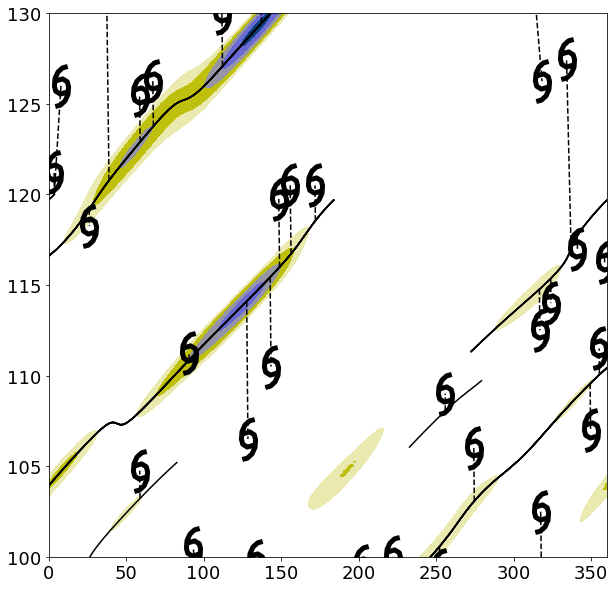

In [7]:
waveName='Kelvin'
speed=14.5
threshold=1.0
days_since_wave_tcs,closest_wave_intensity,tcs_on_peak,tcs_not_on_peak=\
find_closest_wave(tcgen_info[tcgen_info.lat<=20],waveName,speed,threshold,'min_cost_function',init_time)

2.142857142857143 13.285714285714285


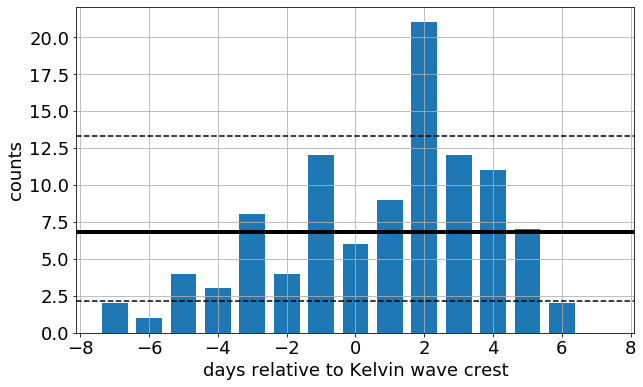

In [8]:
%matplotlib inline

#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(-7.5,7.5,16)
plt.figure(figsize=(10,6))
# hist,bin_edges,patches = plt.hist([days_since_wave_tcs,days_since_wave_ndv],bins=bins)
hist,bin_edges,patches = plt.hist([days_since_wave_tcs],bins=bins,rwidth=0.75)

if (waveName == 'TD'):
    plt.xlabel('days relative to easterly wave crest')
else:
    plt.xlabel('days relative to %s wave crest'%waveName)
plt.ylabel('counts')
# labels = ['DEV (N = %i)'%len(days_since_wave_tcs),'non-DEV (N = %i)'%len(days_since_wave_ndv)]
# plt.legend(labels)
# plt.title('Method #1')
# plt.xlim([-5.5,5.5])

#test for statistical significance following Schreck (2015)
# Defining model parameters
p = 1/ (len(bins)-1)
n = np.sum(hist)#[0])
k = np.linspace(0,max(hist))#[0]))
confidence = 0.99

# Generating survival function distribution and computing the number of required trials
binom = scipy.stats.binom.cdf(k, n, p)
k_025 = k[binom>=1-confidence][0]
k_975 = k[binom>=confidence][0]
print(k_025,k_975)

# Add mean and confidence intervals
plt.axhline(np.mean(hist),color='k',linewidth=4)
plt.axhline(k_025,color='k',linestyle='dashed')
plt.axhline(k_975,color='k',linestyle='dashed')

plt.grid(True)
# plt.title('(a) minimized cost function method',loc='left')

# plt.savefig('./Figures/histogram_DEV_wrt_%s_mincostfunc_%s_1sigma_single_plot.jpg'%(waveName,exp_name),bbox_inches='tight',dpi=150)

Let's check the PDF of waves close to genesis vs all waves

In [ ]:
waveData = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,avgLat=True,minLat=0.0,maxLat=10.0)
waveData = (waveData/waveData.std()).where(waveData/waveData.std()>=1.0)

plt.figure()
bins = np.linspace(0.5,6.5,7)
print(bins)
bins_ctr = 0.5*(bins[1:]+bins[:-1])
print(bins_ctr)
hist, bin_edges = np.histogram(waveData.stack(z=('time','lon')).dropna('z'),bins=bins)
plt.bar(bins_ctr,hist/np.sum(hist))

hist_tcs, bin_edges = np.histogram(closest_wave_intensity,bins=bins)
plt.bar(bins_ctr,hist_tcs/np.sum(hist_tcs),alpha=0.5)

In [ ]:
threshold=1.0
days_since_TD_tcs,closest_TD_intensity,tcs_on_TD_peak=find_closest_wave(
    tcgen_info[tcgen_info.lat<=20],'TD',-5.0,threshold,'min_cost_function',init_time)

waveData = filter_data_for_ccews(fname,obsVar,obsPerDay,'TD',avgLat=True,minLat=-5.0,maxLat=10.0)
waveData = (waveData/waveData.std()).where(waveData/waveData.std()>=threshold)

# --- find the intensity at the wave crests... or use method #2

# plt.figure()
bins = np.linspace(-0.5,6.5,8)
bins_ctr = 0.5*(bins[1:]+bins[:-1])
hist, bin_edges = np.histogram(waveData.stack(z=('time','lon')).dropna('z'),bins=bins)
# plt.bar(bins_ctr,hist/np.sum(hist))
hist_tcs, bin_edges = np.histogram(closest_TD_intensity,bins=bins)
# plt.bar(bins_ctr,hist_tcs/np.sum(hist_tcs),alpha=0.5)

fig, ax = plt.subplots()
width=0.35
rects1 = ax.bar(bins_ctr - width/2, hist/np.sum(hist), width, label='climatology')
rects2 = ax.bar(bins_ctr + width/2, hist_tcs/np.sum(hist_tcs), width, label='TCG')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('fraction')
ax.set_xlabel('normalized wave intensity ($\\sigma$)')
ax.legend()

days_since_Kelvin_tcs,closest_Kelvin_intensity,tcs_on_Kelvin_peak=find_closest_wave(
    tcgen_info[tcgen_info.lat<=20],'Kelvin',14.5,threshold,'min_cost_function',init_time)

waveData = filter_data_for_ccews(fname,obsVar,obsPerDay,'Kelvin',avgLat=True,minLat=-5.0,maxLat=10.0)
waveData = (waveData/waveData.std()).where(waveData/waveData.std()>=threshold)

plt.figure()
bins = np.linspace(-0.5,6.5,8)
bins_ctr = 0.5*(bins[1:]+bins[:-1])
hist, bin_edges = np.histogram(waveData.stack(z=('time','lon')).dropna('z'),bins=bins)
# plt.bar(bins_ctr,hist/np.sum(hist))
hist_tcs, bin_edges = np.histogram(closest_Kelvin_intensity,bins=bins)
# plt.bar(bins_ctr,hist_tcs/np.sum(hist_tcs),alpha=0.5)

fig, ax = plt.subplots()
width=0.35
rects1 = ax.bar(bins_ctr - width/2, hist/np.sum(hist), width, label='climatology')
rects2 = ax.bar(bins_ctr + width/2, hist_tcs/np.sum(hist_tcs), width, label='TCG')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('fraction')
ax.set_xlabel('normalized wave intensity ($\\sigma$)')
ax.legend()

# joint PDFs
hist,_,_ = np.histogram2d(days_since_Kelvin_tcs,days_since_TD_tcs,bins=bins)
[X,Y] = np.meshgrid(bins_ctr,bins_ctr)
plt.figure()
plt.pcolormesh(X,Y,hist)

In [ ]:
from matplotlib.ticker import NullFormatter, MaxNLocator
import matplotlib.colors as mcolors
import matplotlib.cm as cm
#increase font size
plt.rcParams.update({'font.size': 14})

#choose a colormap
cmap = cm.magma_r
colorparams=np.arange(0,7)
normalize=mcolors.Normalize(vmin=0,vmax=7)

# Define the locations for the axes
left, width = 0.12, 0.55
bottom, height = 0.12, 0.55
bottom_h = left_h = left+width+0.03
 
# Set up the geometry of the three plots
rect_hist2d = [left, bottom, width, height] # dimensions of temp plot
rect_histx = [left, bottom_h, width, 0.25] # dimensions of x-histogram
rect_histy = [left_h, bottom, 0.25, height] # dimensions of y-histogram
 
# Set up the size of the figure
fig = plt.figure(1, figsize=(9.5,9))
 
# Make the three plots
axHist2d = plt.axes(rect_hist2d) # temperature plot
axHistx = plt.axes(rect_histx) # x histogram
axHisty = plt.axes(rect_histy) # y histogram

# Remove the inner axes numbers of the histograms
nullfmt = NullFormatter()
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# joint PDFs
bins = np.linspace(-7.5,7.5,16)
bins_ctr = 0.5*(bins[1:]+bins[:-1])
hist,_,_ = np.histogram2d(days_since_Kelvin_tcs,days_since_TD_tcs,bins=bins)
[X,Y] = np.meshgrid(bins,bins)
cf=axHist2d.pcolormesh(X,Y,hist,cmap=cmap,norm=normalize)
axHist2d.set_xlabel('days w.r.t. easterly wave')
axHist2d.set_ylabel('days w.r.t. Kelvin wave')
axHist2d.grid(True)

#colorbar setup
s_map = cm.ScalarMappable(norm=normalize,cmap=cmap)
s_map.set_array(colorparams)
halfdist = 0.5*(colorparams[1]-colorparams[0])
boundaries = np.linspace(colorparams[0]-halfdist,colorparams[-1]+halfdist,len(colorparams)+1)
cb=fig.colorbar(s_map,spacing='proportional',boundaries=boundaries,ticks=colorparams)
cb.set_label('counts')

# single PDFs
axHistx.hist(days_since_TD_tcs,bins=bins,color='gray')
axHistx.set_ylabel('counts')
axHistx.grid(True)
axHisty.hist(days_since_Kelvin_tcs,bins=bins,orientation='horizontal',color='gray')
axHisty.set_xlabel('counts')
axHisty.grid(True)

plt.savefig('./Figures/joint_histograms_Kelvin+TD_1sigma_r3600x1800.jpeg',dpi=150,bbox_inches='tight')

### Method #2

In [ ]:
waveName='Kelvin'
threshold=1.0
days_since_wave_tcs,wavePhase_tcgen_tcs,waveInt_tcgen_tcs,waveInt_closest_tcs = \
            find_closest_wave(tcgen_info[tcgen_info.lat <= 20],waveName,14.5,threshold,'wave_phase',init_time)

In [ ]:
# days_since_wave_ndv,wavePhase_tcgen_ndv,waveInt_tcgen_ndv,waveInt_closest_ndv = \
#             find_closest_wave(analogs_ndv,waveData,14.5,1.0,'wave_phase',init_time)

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(-7.5,7.5,16)
plt.figure(figsize=(10,6))
# hist,bin_edges,patches = plt.hist([np.array(days_since_wave_tcs),np.array(days_since_wave_ndv)],bins=bins,alpha=0.75)
hist,bin_edges,patches = plt.hist(np.array(days_since_wave_tcs),bins=bins,rwidth=0.75)
if (waveName == 'TD'):
    plt.xlabel('days w.r.t. easterly wave active phase')
else:
    plt.xlabel('days relative to %s wave active phase'%waveName)
plt.ylabel('counts')
# plt.legend(labels)
# plt.title('Method #2')
plt.xlim([-8.5,8.5])

#test for statistical significance following Schreck (2015)
# Defining model parameters
p = 1/ (len(bins)-1)
n = np.sum(hist)#[0])
k = np.linspace(0,max(hist))#[0]))
confidence = 0.99

# Generating survival function distribution and computing the number of required trials
binom = scipy.stats.binom.cdf(k, n, p)
k_025 = k[binom>=1-confidence][0]
k_975 = k[binom>=confidence][0]

# Add mean and confidence intervals
plt.axhline(np.mean(hist),color='k',linewidth=4)
plt.axhline(k_025,color='k',linestyle='dashed')
plt.axhline(k_975,color='k',linestyle='dashed')

plt.grid(True)
plt.title('(b) wave phase method',loc='left')

plt.savefig('./Figures/histogram_DEV_wrt_%s_wavePhase_%s_1sigma.jpg'%(waveName,exp_name),bbox_inches='tight',dpi=150)

In [ ]:
# confirmed: TCs are forming from "AD" or "ER"s

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(0.5,8.5,9)
plt.figure(figsize=(10,6))
# plt.hist([np.array(wavePhase_tcgen_tcs),np.array(wavePhase_tcgen_ndv)],bins=bins,alpha=0.75)
plt.hist(np.array(wavePhase_tcgen_tcs),bins=bins,alpha=0.75)
plt.xlabel('wave phase')
plt.ylabel('counts')
plt.legend(labels)

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 18})

bins = np.linspace(-5.5,5.5,11)
plt.figure(figsize=(10,6))
# plt.hist([np.array(waveInt_tcgen_tcs),np.array(waveInt_tcgen_ndv)],bins=bins,alpha=0.75)
plt.hist(np.array(waveInt_tcgen_tcs),bins=bins,alpha=0.75)
plt.xlabel('wave intensity')
plt.ylabel('counts')
plt.legend(labels)
plt.title('Method #2')

# print(np.mean(waveInt_tcgen_tcs),np.mean(waveInt_tcgen_ndv))

In [ ]:
# plt.hist(waveInt_closest_tcs)

waveData = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,avgLat=True,minLat=0.0,maxLat=10.0)
waveDatadt = waveData.differentiate('time')

#normalize by the standard deviation
waveData = waveData/np.std(waveData)
waveDatadt = waveDatadt/np.std(waveDatadt)

#obtain angle between wave intensity and tendency
theta = xr.ufuncs.arctan2(waveDatadt,waveData)
#pivot the angle so that it ranges from -pi/8 to 15*pi./8
theta = (theta+(2*np.pi))%(2*np.pi)
print(theta.min(),theta.max())
theta = theta.where(theta<15.0*np.pi/8.0,theta-2.0*np.pi) #] = theta[theta>=15.0*np.pi/8.0]-2.0*np.pi
print(theta.min(),theta.max())

waveData = waveData.where( ((waveData**2.0+waveDatadt**2.0)**0.5 >= threshold) & (theta>=-np.pi/8.0) & (theta<=np.pi/8.0) )
print(waveData.min(),waveData.max())

# ----- get histogram & plot ------ #
bins = np.linspace(-0.5,6.5,8)
bins_ctr = 0.5*(bins[1:]+bins[:-1])
hist, bin_edges = np.histogram(waveData.stack(z=('time','lon')).dropna('z'),bins=bins)
hist_tcs, bin_edges = np.histogram(waveInt_closest_tcs,bins=bins)

fig, ax = plt.subplots(figsize=(12,5))
width=0.35
rects1 = ax.bar(bins_ctr - width/2, hist/np.sum(hist), width, label='all easterly waves')
rects2 = ax.bar(bins_ctr + width/2, hist_tcs/np.sum(hist_tcs), width, label='easterly waves that undergo TCG')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('fraction')
ax.set_xlabel('normalized wave intensity ($\\sigma$)')
ax.legend()

# plt.savefig('histogram_waveInt_climoVSTCG_%s.jpeg'%(waveName),bbox_inches='tight',dpi=150)

### Plot maps w.r.t. TC genesis

In [ ]:
df_sub = tcgen_info[tcgen_info.lat<=20.0]#[tcgen_info.ID.isin(tcs_on_peak)]
len(df_sub)

In [ ]:
import datetime 

a1 = 10.**(np.arange(-2, 1)) 
a2 = np.arange(1,10,1)
levels = np.outer(a1, a2).flatten()
levels = levels[levels>=0.01]
levels = levels[levels<=1.0]

my_dict = {
    'pr': [1.0,'Blues', levels, 'rainfall rate anomaly (mm hr$^{-1}$)'],
    'u850': [1,'RdBu_r',np.linspace(-5,5,21),'850-hPa zonal wind anomaly (m s$^{-1}$)'],
    'v850': [1,'RdBu_r',np.linspace(-3,3,21),'850-hPa meridional wind anomaly (m s$^{-1}$)'],
    'u200': [1,'RdBu_r',np.linspace(-3,3,21),'200-hPa zonal wind anomaly (m s$^{-1}$)'],
    'precipw': [1,'BrBG',np.linspace(-5.0,5.0,21),'precipitable water anomaly (mm)'],
    'mse_vint': [1.0e-6,'coolwarm',np.linspace(-10.0,10.0,21),'<h> (J m$^{-2}$)'],
    'ushr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa zonal shear (m s$^{-1}$)'],
    'vshr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa meridional shear (m s$^{-1}$)'],
    'shrmag': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa shear magnitude (m s$^{-1}$)'],
    'vort850': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850-hPa relative vorticity anomaly (10$^{-5}$ s$^{-1}$)'],
    'circ_vint': [1.0e5,'RdGy',np.linspace(-3.5,3.5,21),'vertically-integrated circulation anomaly (10$^{-5}$ s$^{-1}$)'],
    'qv500':[1000.0,'BrBG',np.linspace(-0.6,0.6,21),'500-hPa water vapor mixing ratio (g kg$^{-1}$)'],
    'rhmid':[1.0,'BrBG',np.linspace(-10.0,10.0,21),'500-700 hPa relative humidity (%)'],
    'mslp': [1.0,'viridis',np.linspace(-10,10,21),'mslp'],
    'hfx': [1.0,'RdBu_r',np.linspace(-10,10,21),'surface sensible heat flux (W m$^{-2}$)'],
    'qfx': [2.5e6,'RdBu_r',np.linspace(-20,20,21),'surface latent heat flux (W m$^{-2}$)'],
    'CI': [1.0,'RdBu_r',np.linspace(-1.25,1.25,21),'coupling index (K)'],
    'olrtoa': [1.0,'Greys',np.linspace(-50,50,21),'outgoing longwave radiation anomaly (W m$^{-2}$)'],
    'SF' : [1.0,'RdBu_r',np.linspace(-10,10,21),'surface heat fluxes anomaly (W m$^{-2}$)'],
    'R' : [1.0,'RdBu_r',np.linspace(-10,10,21),'radiative fluxes anomaly (W m$^{-2}$)'],
    'VI' : [1.0,'RdBu_r',np.linspace(-0.05,0.05,21),'ventilation index anomaly'],
    'div200': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'200-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)'],
    'divlo': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850$-$1000-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)']
}

def get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,**kwargs):

        def read_stormcentered_fields_latlon(ds,dLon,dLat,nDays,varname,df,plotting_options):
                        
            lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
            lat_array_target = xr.DataArray(np.arange(-dLat,dLat+dx,dx))

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                clat = plotting_options['clat']

            centered_data_0s = np.zeros( (len(df),len(lat_array_target),len(lon_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','lat','lon'))#,coords=(IDs,tim_array_target,lon_array_target),dims=('ID','time','lon'))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')+pd.to_timedelta(nDays,unit='D')
                clon = row['lon']
                
                if (ctim < ds.time[0].values) | (ctim > ds.time[-1].values):
                    print(ctim)
                    #still not working!!!
                    continue

                if (plotting_options['lat_option'] == 'TC'):
                    clat = row['lat']
                    print(clat)

                var2tst = ds[varname].sel(time=ctim)
                
                if (plotting_options['TC_removal']):
                    df_sub = df_all[df_all.fhr==(row['fhr']+(nDays*24))]

                    for index_sub, row_sub in df_sub.iterrows():
                        dist = gcdist(row_sub['lon'],ds.lon,row_sub['lat'],ds.lat)
                        var2tst_tc = var2tst.where(dist<=300.0,0.)
                        var2tst = var2tst-var2tst_tc    
                        
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')
                var2tst['lat'] = var2tst.lat-ds.lat.sel(lat=clat,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2),lat=slice(-(dLat+dx/2),dLat+dx/2))

                ds_out[d,:,:] = var_intrp

                if (plot_individual_tcs):
                    plt.figure()
                    plt.contourf(ds_out[d,:,:])
                    plt.title(row['ID'])

                d += 1
            print('total no. tcs in composite: %i'%d)
            return ds_out,lon_array_target,lat_array_target


        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'clat' : 15.0,
            'subtract_zonal_time_mean' : True,
            'overlay' : False,
            'TC_removal' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
            
        print(plotting_options)
            
        #read netcdf file
        ds = xr.open_dataset(fname)
        obsTime = ds.time
        
        if (varname == 'SF'):
            ds[varname] = ds.qfx*2.5e6 + ds.hfx
        elif (varname == 'R'):
            fnameRad = pth+'/latlon/radFluxes.nc'
            ds = xr.open_dataset(fnameRad)
            zlw_top = (-ds.olrtoa)
            zsw_top = (ds.swdnt-ds.swupt)

            zlw_sfc = ((ds.lwdnb-ds.lwupb))
            zsw_sfc = ((ds.swdnb-ds.swupb))

            znet_top = zlw_top + zsw_top
            znet_sfc = zlw_sfc + zsw_sfc
            znet = (znet_top - znet_sfc)          
            ds[varname] = znet 
        elif (varname=='VI'):
            fnameVI=pth+'/latlon/genesis_indexes.nc'
            ds[varname]=xr.open_dataset(fnameVI)[varname]

        #drop unnecessary variables
        keep_vars = ['time','lat','lon',varname]
        
        ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
        dx = np.abs(ds.lon[1].values-ds.lon[0].values)
        obsTime = ds.time
        ds = ds.sortby('lat')
            
        if (plotting_options['overlay']):
            varname1 = varname
            varname2 = kwargs['varname2']
            plotting_options_var1 = plotting_options.copy()
            plotting_options_var2 = plotting_options.copy()
                        
            for keys in kwargs:
                if ("var1" in keys):
                    delim = "_"
                    keys1 = keys.split(delim)[:-1]
                    plotting_options_var1[delim.join(keys1)]=kwargs[keys]
                elif ("var2" in keys):
                    delim = "_"
                    keys2 = keys.split(delim)[:-1]
                    plotting_options_var2[delim.join(keys2)]=kwargs[keys]
            
            #subtract mean or filter for each wave
            if plotting_options_var1['subtract_zonal_time_mean']:
                time_zonal_mean_var = ds[varname1].mean(dim=('time','lon'))
                ds[varname1] = ds[varname1] - time_zonal_mean_var

            if plotting_options_var2['filtWaves']:
                #calling filtering function
                #varname2='filtered'
                newVarName2 = varname2+'filtered'
                tmp = filter_data_for_ccews(fname,varname2,obsPerDay,waveName,minLat=-5,maxLat=15,avgLat=False)
                varname2 = newVarName2
                ds[varname2]=tmp
            
        for lag in nDays:

            fig, ax = plt.subplots(figsize=(16,4))
            
            if (plotting_options['overlay']):
                                
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname1,df,plotting_options_var1)
                centered_data_avg1 = centered_data.mean(dim='ID')*my_dict[varname1][0]
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname2,df,plotting_options_var2)
                centered_data_avg2 = centered_data.mean(dim='ID')
                print(centered_data_avg1.min(),centered_data_avg1.max())
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                [X,Y] = np.meshgrid(lon,lat)
                cf = ax.contourf(X,Y,centered_data_avg1,extend='both',cmap=my_dict[varname][1], 
                                   levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
                cl = ax.contour(X,Y,centered_data_avg2,colors='k',levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
                
            else:
                
                if plotting_options['subtract_zonal_time_mean']:
                    time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
                    ds[varname] = ds[varname] - time_zonal_mean_var

                if plotting_options['filtWaves']:
                    #calling filtering function
                    ds[varname] = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,minLat=plotting_options['clat']-dLat,maxLat=plotting_options['clat']+dLat,avgLat=False)
                    
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname,df,plotting_options)
                centered_data_avg = centered_data.mean(dim='ID')*my_dict[varname][0]
                print(centered_data_avg.min(),centered_data_avg.max())
            
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                [X,Y] = np.meshgrid(lon,lat)
                cf = ax.contourf(X,Y,centered_data_avg,extend='both',cmap=my_dict[varname][1], 
                                   levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
                cl = ax.contour(X,Y,centered_data_avg,levels=[0.],colors='k',linestyles='dashed')
                
            ax.set_xlabel('longitude w.r.t. cyclogenesis')
            ax.set_ylabel('latitude')
    #        plt.hlines(0,-dLon,dLon)
            plt.vlines(0,np.min(lat),np.max(lat))
            ax.grid(True)
            plt.title('t = %i days'%lag)

            cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
            cbar=fig.colorbar(cf, cax=cbar_ax,orientation='horizontal')
            cbar.set_label(my_dict[varname][3])
            fig.tight_layout(pad=0.1)

            
            #add panel labels
            plt.text(left, top, '%s (N = %i)'%(TCgroup,len(df)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize='18', bbox=dict(facecolor='white'))
            display(fig)      
            
            # plt.savefig('%s_latlon_%s_%s_%sdays.jpg'%(varname,exp_name,TCgroup,lag),bbox_inches='tight',dpi=150)
            plt.close()

In [ ]:
nDays = [-5,-4,-3,-2,-1,0,1,2]
varname = 'u850'
TCgroup = 'DEV'
fname = pth+'latlon/diags_gaussian_global_nospinup_n400.nc'
ds = xr.open_dataset(fname)

dLon=45.0
dLat = 11.25
lat_option='eq'
plot_individual_tcs=False
waveName = 'TD'
# get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df_sub,lat_option=lat_option,clat=dLat/2,
#                         filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
#                         filtWaves_var2=True,subtract_zonal_time_mean_var2=False,TC_removal=False,TC_removal_var2=False)

In [ ]:
varname = 'R'
waveName = 'TD'
# get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df_sub,lat_option=lat_option,clat=dLat/2,
#                         filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
#                         filtWaves_var2=True,subtract_zonal_time_mean_var2=False,TC_removal=False,TC_removal_var2=False)

In [ ]:
varname = 'SF'
waveName = 'TD'
# get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df_sub,lat_option=lat_option,clat=dLat/2,
#                         filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
#                         filtWaves_var2=True,subtract_zonal_time_mean_var2=False,TC_removal=False,TC_removal_var2=False)

In [ ]:
varname = 'mse_vint'
waveName = 'Kelvin'
get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df_sub,lat_option=lat_option,clat=dLat/2,
                        filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
                        filtWaves_var2=True,subtract_zonal_time_mean_var2=False,TC_removal=False,TC_removal_var2=False)

#### Attempt the circulation budget of Murthy and Boos (2008) 

In [ ]:
#needed: vertically averaged circulation, surface fluxes, and radiation 
#ideally we want these quantities following the TC, but we'll do them on geographic space for now
#also, let's go only with vort850 for now
from scipy.stats import pearsonr

def get_plot_circ_vs_thermo(fname,dLon,dLat,laggedDays,df,**kwargs):

        def read_stormcentered_fields_latlon(ds,dLon,dLat,nDays,varname,df,plotting_options):
                        
            lon_array_target = xr.DataArray(np.arange(-(dLon),dLon+dx,dx))
            lat_array_target = xr.DataArray(np.arange(-(dLat),dLat,dy)) #trick to work w/ gaussian grid

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                clat = plotting_options['clat']

            centered_data_0s = np.zeros( (len(df),len(lat_array_target),len(lon_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','lat','lon'),coords=(IDs,lat_array_target,lon_array_target))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')+pd.to_timedelta(nDays,unit='D')
                clon = row['lon']
                
                if (ctim < ds.time[0].values) | (ctim > ds.time[-1].values):
                    # print(ctim)
                    continue

                if (plotting_options['lat_option'] == 'TC'):
                    df_tc = df_all[(df_all.ID == row['ID']) & (df_all.valid_time==ctim.strftime(format='%Y-%m-%d_%H.%M.%S'))]
                    if (df_tc.empty):
                        print('no TC data')
                        continue
                    else:
                        clon = df_tc.lon.values[0]
                        clat = df_tc.lat.values[0]

                else:
                    clon = row['lon']

                var2tst = ds[varname].sel(time=ctim)
                
                if (plotting_options['TC_removal']):
                    df_sub = df_all[df_all.fhr==(row['fhr']+(nDays*24))]

                    for index_sub, row_sub in df_sub.iterrows():
                        dist = gcdist(row_sub['lon'],ds.lon,row_sub['lat'],ds.lat)
                        var2tst_tc = var2tst.where(dist<=300.0,0.)
                        var2tst = var2tst-var2tst_tc    
                        
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')
                var2tst['lat'] = var2tst.lat-ds.lat.sel(lat=clat,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                # print(var2tst.lon.sel(lon=slice(-(dLon+dx/2),dLon+dx/2)))
                # print(var2tst.lat.sel(lat=slice(-(dLat+dx/2),dLat+dx/2)))
                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2),lat=slice(-(dLat+dx/2),dLat+dx/2))

                ds_out[d,:,:] = var_intrp.values

                if (plot_individual_tcs):
                    plt.figure()
                    plt.contourf(ds_out[d,:,:])
                    plt.title(row['ID'])

                d += 1
            print('total no. tcs in composite: %i'%d)
            return ds_out,lon_array_target,lat_array_target


        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'clat' : 15.0,
            'subtract_zonal_time_mean' : True,
            'overlay' : False,
            'TC_removal' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
            
        print(plotting_options)
            
        #read netcdf file
        ds = xr.open_dataset(fname).sel(lat=slice(40,-15))
        obsTime = ds.time
        
        #calculate radiative and surface fluxes
        ds['SF'] = ds.qfx*2.5e6 + ds.hfx
        print(ds.SF.min(),ds.SF.max())
        # #remove the zonal mean
        ds['SF'] = ds['SF']-ds['SF'].mean('lon')
        
        #radiative fluxes are on a different dataset
        fnameRad = pth+'/latlon/radFluxes.nc'
        dsR = xr.open_dataset(fnameRad)
        zlw_top = (-dsR.olrtoa)
        zsw_top = (dsR.swdnt-dsR.swupt)

        zlw_sfc = ((dsR.lwdnb-dsR.lwupb))
        zsw_sfc = ((dsR.swdnb-dsR.swupb))

        znet_top = zlw_top + zsw_top
        znet_sfc = zlw_sfc + zsw_sfc
        znet = (znet_top - znet_sfc)          
        ds['R'] = znet - znet.mean('time').mean('lon')

        #drop unnecessary variables
        ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon','SF','circ_vint','R']])
        dx = np.abs(ds.lon[1].values-ds.lon[0].values)
        dy = np.abs(ds.lat[1].values-ds.lat[0].values)

        obsTime = ds.time
        ds = ds.sortby('lat')
        
        circ = xr.DataArray(np.empty( (len(laggedDays),len(df)) ),dims=['laggedDays','ID'],coords=[laggedDays,df.ID])
        sflx = xr.DataArray(np.empty( (len(laggedDays),len(df)) ),dims=['laggedDays','ID'],coords=[laggedDays,df.ID])
        rflx = xr.DataArray(np.empty( (len(laggedDays),len(df)) ),dims=['laggedDays','ID'],coords=[laggedDays,df.ID])
        
        for i in np.arange(0,len(laggedDays)):
            lag = laggedDays[i]
                
            # if plotting_options['subtract_zonal_time_mean']:
            #     time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
            #     ds[varname] = ds[varname] - time_zonal_mean_var
 
            # ----- vorticity
            centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,'circ_vint',df,plotting_options)
            circ[i,:] = centered_data.sel(lat=slice(-2.5,2.5),lon=slice(-2.5,2.5)).mean(dim=('lat','lon')).values
            del(centered_data)
            # fig=plt.figure()
            # [X,Y]=np.meshgrid(lon,lat)
            # plt.contourf(X,Y,centered_data.mean('ID'))
            # plt.title('circ')
            # display(fig)
            # plt.close()
            
            # ----- surface fluxes
            centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,'SF',df,plotting_options)
            #remove the spatial mean
            # centered_data = centered_data-centered_data.mean(dim=('lat','lon'))
            sflx[i,:] = centered_data.sel(lat=slice(-2.5,2.5),lon=slice(-2.5,2.5)).mean(dim=('lat','lon')).values
            del(centered_data)
            # fig=plt.figure()
            # [X,Y]=np.meshgrid(lon,lat)
            # plt.contourf(X,Y,centered_data.mean('ID'))
            # plt.title('SF')
            # display(fig)
            # plt.close()

            # # ----- radiation
            centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,'R',df,plotting_options)
            rflx[i,:] = centered_data.sel(lat=slice(-5,5),lon=slice(-5,5)).mean(dim=('lat','lon')).values

       
        #we have all the data, now let's average and create some plots
        
        # ----- time series
        plt.figure()
        var2plt = circ#xr.DataArray(np.gradient(circ,axis=0),dims=circ.dims,coords=circ.coords)
        plt.plot(laggedDays,var2plt.mean('ID'))
        plt.ylabel('circ')
        plt.xlabel('days')
        
        plt.figure()
        plt.plot(laggedDays,sflx.mean('ID'))
        plt.ylabel('SF')
        plt.xlabel('days')
        
        plt.figure()
        plt.plot(laggedDays,rflx.mean('ID'))
        plt.ylabel('R')
        plt.xlabel('days')
        
        # ------ scatter plots
        x = (sflx).mean('laggedDays')#np.mean(sflx,axis=0)
        y = var2plt.mean('laggedDays')#circ.diff('laggedDays').mean('laggedDays')#np.mean(circ,axis=0)
        
        #remove NaNs
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]

        corr, _ = pearsonr(x,y)
        print('Pearsons correlation: %.3f' % corr)
        
        plt.figure()
        plt.scatter(x,y)
        plt.ylabel('circ')
        plt.xlabel('SF')
        plt.ylim([y.min(),y.max()])
        
        x = (sflx).stack().values
        y = (var2plt).stack().values
        
        #remove NaNs
        x = x[~np.isnan(x)]
        y = y[~np.isnan(y)]

        corr, _ = pearsonr(x,y)
        print('Pearsons correlation: %.3f' % corr)
        
        plt.figure()
        plt.scatter(x,y)
        plt.ylabel('circ')
        plt.xlabel('SF')
        plt.ylim([y.min(),y.max()])
        
        return circ,sflx
                

In [ ]:
fname = pth+'latlon/diags_gaussian_global_nospinup_n400.nc'

del(ds)
ds = xr.open_dataset(fname)

dLon=0.225*44#/2
dLat = dLon
lat_option='TC'
plot_individual_tcs=False

laggedDays = np.arange(-3.0,1.25,0.25)

df_sub = tcgen_info[tcgen_info.lat<=20.0]
# df_sub = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]

print(len(df_sub))

circ_sub1, sflx_sub1 = get_plot_circ_vs_thermo(fname,dLon,dLat,laggedDays,df_sub,lat_option=lat_option)

In [ ]:
df_sub = tcgen_info[(~tcgen_info.ID.isin(tcs_on_peak)) & (tcgen_info.lat<=20.0)]

print(len(df_sub))

circ_sub2, sflx_sub2 = get_plot_circ_vs_thermo(fname,dLon,dLat,laggedDays,df_sub,lat_option=lat_option)

In [ ]:
plt.figure()

# ----- time series
plt.figure()
var2plt = sflx_sub1#xr.DataArray(np.gradient(circ_sub1,axis=0),dims=circ_sub1.dims,coords=circ_sub1.coords)
plt.plot(circ_sub1.laggedDays,var2plt.mean('ID'))
print(var2plt.mean('laggedDays').mean())
var2plt = sflx_sub2#xr.DataArray(np.gradient(circ_sub2,axis=0),dims=circ_sub2.dims,coords=circ_sub2.coords)
plt.plot(circ_sub2.laggedDays,var2plt.mean('ID'))
print(var2plt.mean('laggedDays').mean())
plt.ylabel('circ')
plt.xlabel('days')

### Plot composites of 1D quantities

In [ ]:
def get_plot_1d_composites_wrt_genesis(fname,dLon,dLat,nDays,varname,df,**kwargs):

    def read_stormcentered_fields_lon(ds,dLon,dLat,nDays,varname,df,plotting_options):

        lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
        lat_array_target = xr.DataArray(np.arange(-dLat,dLat+dx,dx))

        if (plotting_options['lat_option'] == 'eq'):
            #subtract zonal and time mean at that latitude
            clat = plotting_options['clat']

        centered_data_0s = np.zeros( (len(df),len(lon_array_target)) )
        centered_data_0s[:] = np.nan
        IDs = np.arange(0,len(df))

        ds_out = xr.DataArray(centered_data_0s,dims=('ID','lon'))#,coords=(IDs,tim_array_target,lon_array_target),dims=('ID','time','lon'))

        #loop through data, obtain datetime object for valid time, and get corresponding index
        d = 0
        for index, row in df.iterrows():
            ctim = pd.to_datetime(row['valid_time'],format='%Y-%m-%d_%H.%M.%S')+pd.to_timedelta(nDays,unit='D')
            clon = row['lon']

            if (ctim < ds.time[0].values) | (ctim > ds.time[-1].values):
                print(ctim)
                #still not working!!!
                continue

            if (plotting_options['lat_option'] == 'TC'):
                clat = row['lat']
                print(clat)

            var2tst = ds[varname].sel(time=ctim)

            if (plotting_options['TC_removal']):
                df_sub = df_all[df_all.fhr==(row['fhr']+(nDays*24))]

                for index_sub, row_sub in df_sub.iterrows():
                    dist = gcdist(row_sub['lon'],ds.lon,row_sub['lat'],ds.lat)
                    var2tst_tc = var2tst.where(dist<=300.0,0.)
                    var2tst = var2tst-var2tst_tc    

            var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')
            var2tst['lat'] = var2tst.lat-ds.lat.sel(lat=clat,method='nearest')

            if (var2tst.lon.max() < lon_array_target.max()):
                #need to find lon<-180 and add 360
                lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                #reassign longitude coordinate
                var2tst['lon'] = lon_temp
                #pivot around longitude 0 by finding longitudes <=0 and those > 0
                group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                #make sure that the coordinate is in ascending order
                group2 = group2.sortby(group2.lon)
                del(var2tst)
                #finally merge the two!
                var2tst = xr.concat([group1,group2],dim='lon')
            elif (var2tst.lon.min() > lon_array_target.min() ):
                lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                var2tst['lon'] = lon_temp
                group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                group1 = group1.sortby(group1.lon)
                group2 = group2.sortby(group2.lon)
                del(var2tst)
                var2tst = xr.concat([group1,group2],dim='lon')

            var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2),lat=slice(-(dLat+dx/2),dLat+dx/2)).mean('lat')

            ds_out[d,:] = var_intrp

            if (plot_individual_tcs):
                plt.figure()
                plt.contourf(ds_out[d,:,:])
                plt.title(row['ID'])

            d += 1
        print('total no. tcs in composite: %i'%d)
        return ds_out,lon_array_target

    plotting_options = {
        'filtWaves' : False,
        'lat_option' :'eq',
        'clat' : 15.0,
        'subtract_zonal_time_mean' : True,
        'overlay' : False,
        'TC_removal' : False
    }

    for keys in kwargs:
        plotting_options[keys] = kwargs[keys]

    print(plotting_options)

    #read netcdf file
    ds = xr.open_dataset(fname)
    obsTime = ds.time

    #drop unnecessary variables
    keep_vars = ['time','lat','lon',varname]

    ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
    dx = np.abs(ds.lon[1].values-ds.lon[0].values)
    obsTime = ds.time
    ds = ds.sortby('lat')


    fig, ax = plt.subplots(figsize=(16,4))
    for lag in nDays:

        if plotting_options['subtract_zonal_time_mean']:
            time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
            ds[varname] = ds[varname] - time_zonal_mean_var

        if plotting_options['filtWaves']:
            #calling filtering function
            ds[varname] = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,minLat=plotting_options['clat']-dLat,maxLat=plotting_options['clat']+dLat,avgLat=False)

        centered_data,lon = read_stormcentered_fields_lon(ds,dLon,dLat,lag,varname,df,plotting_options)
        centered_data_avg = centered_data.mean(dim='ID')*my_dict[varname][0]
        print(centered_data_avg.min(),centered_data_avg.max())

        ax.plot(lon,centered_data_avg,label=lag)#,norm=norm,cmap=cmap)
        display(fig)
    ax.set_xlabel('longitude w.r.t. cyclogenesis')
    ax.set_ylabel(my_dict[varname][3])
#        plt.hlines(0,-dLon,dLon)
    # plt.vlines(0,np.min(lat),np.max(lat))
    ax.grid(True)
    # plt.legend(True)


In [ ]:
nDays = [-5,-3,-2,-1,0,1,2]
varname = 'precipw'
TCgroup = 'DEV'
ds = xr.open_dataset(fname)

dLon=45.0
dLat = 11.25
lat_option='TC'
plot_individual_tcs=False
waveName = 'Kelvin'

get_plot_1d_composites_wrt_genesis(fname,dLon,dLat,nDays,varname,df_sub)

### Plot time-series of circulation leading to cyclogenesis/analog time 
(for TCs at 0.5-3.5 days after wave peak)

In [ ]:
def get_avg_timeseries(subgroup,info):
    print("********")
    plt.figure()

    df_sub = df_all[df_all.ID.isin(subgroup)]
    print(len(df_sub.ID.unique()))

    out = []

    for i in df_sub.ID.unique():
        df_tc = df_sub[df_sub.ID==i]
        print(len(df_tc))
        df_tc['fhr'] = df_tc['fhr'].values-info[info.ID==i].fhr.values
        out.append(df_tc)
        plt.plot(df_tc.fhr.values,df_tc.pmin)
    plt.xlim([-120,120])

    out = pd.concat(out)
    subgroup_avg = out.groupby('fhr').mean()
    subgroup_std = out.groupby('fhr').std()
    
    return subgroup_avg,subgroup_std

# all_tcs = tcgen_info.ID.unique()
# all_ndv = analogs_ndv.ID.unique()
# print(len(tcs_on_peak),len(ndv_on_peak))
all_tcs = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)].ID.unique()
all_ndv = tcgen_info[tcgen_info.ID.isin(tcs_not_on_peak)].ID.unique()
#tcgen_info[(~tcgen_info.ID.isin(tcs_on_peak)) & (tcgen_info.lat<=20.0)].ID.unique()
avg_vor_tcs,std_vor_tcs = get_avg_timeseries(tcs_on_peak,tcgen_info)
avg_vor_ndv,std_vor_ndv = get_avg_timeseries(all_ndv,tcgen_info)

# avg_vor_ndv,std_vor_ndv = get_avg_timeseries(ndv_on_peak,analogs_ndv)

plt.figure(figsize=(10,6))
plt.plot(avg_vor_tcs.index,avg_vor_tcs.pmin,linewidth=4)
# plt.fill_between(avg_vor_tcs.index, avg_vor_tcs.vor850-std_vor_tcs.vor850, \
                 # avg_vor_tcs.vor850+std_vor_tcs.vor850, alpha=0.25)

plt.plot(avg_vor_ndv.index,avg_vor_ndv.pmin,linewidth=4)
# plt.fill_between(avg_vor_ndv.index, avg_vor_ndv.vor850-std_vor_ndv.vor850, \
                 # avg_vor_ndv.vor850+std_vor_ndv.vor850, alpha=0.25)
# plt.xlim([-72,72])
# plt.ylim([0,7.5])
# labels = ['DEV (N = %i)'%len(tcs_on_peak),'non-DEV (N = %i)'%len(ndv_on_peak)]
plt.legend(labels,loc='upper left')
plt.xlabel('time w.r.t. genesis (h)')
plt.ylabel('pmin')#vmax (m s$^{-1}$)')

# plt.vlines(0,0,avg_vor_tcs.vor850.max())

# plt.savefig('timeseries_DEVvsnonDEV_vor850.jpg',bbox_inches='tight',dpi=150)

In [ ]:
def get_data_per_group(subgroup,info):
    plt.figure()

    df_sub = df_all[df_all.ID.isin(subgroup)]
    out = []

    for i in df_sub.ID.unique():
        df_tc = df_sub[df_sub.ID==i]
        df_tc['fhr'] = df_tc['fhr'].values-info[info.ID==i].fhr.values
        out.append(df_tc)
        plt.plot(df_tc.fhr.values,df_tc.pmin)
    plt.xlim([-120,120])

    out = pd.concat(out)
    return out

data_KelvinTCG = get_data_per_group(tcs_on_peak,tcgen_info)
data_notKelvinTCG = get_data_per_group(tcs_not_on_peak,tcgen_info)

In [ ]:
data_KelvinTCG['dvdt'] = data_KelvinTCG['vmax'].diff()
data_notKelvinTCG['dvdt'] = data_notKelvinTCG['vmax'].diff()

#plot histograms
plt.figure()
plt.hist(data_KelvinTCG[data_KelvinTCG.fhr > 0.0].dvdt)
plt.hist(data_notKelvinTCG[data_notKelvinTCG.fhr > 0.0].dvdt)

#percentiles
x90KelvinTCG = np.percentile(data_KelvinTCG[data_KelvinTCG.fhr > 0.0].dvdt,90)
x90notKelvinTCG = np.percentile(data_notKelvinTCG[data_notKelvinTCG.fhr > 0.0].dvdt,90)
print(x90KelvinTCG)
print(x90notKelvinTCG)

Not a clear difference in dvdt, but only considering 6-hr changes...

In [ ]:
# Checking lifetime
plt.figure()
plt.hist(data_KelvinTCG[data_KelvinTCG.fhr > 0.0].groupby('ID').count().vmax)
plt.hist(data_notKelvinTCG[data_notKelvinTCG.fhr > 0.0].groupby('ID').count().vmax)

data_KelvinTCG[data_KelvinTCG.fhr > 0.0].groupby('ID').count().vmax.median(),data_notKelvinTCG[data_notKelvinTCG.fhr > 0.0].groupby('ID').count().vmax.median()

Also not a dramatic change in lifetime.

### Next: center-relative hovmollers

In [ ]:
my_dict = {
    'pr': [1.0,'Blues', np.linspace(-0.02*1.5,0.34*1.5,19), 'rainfall rate anomaly (mm hr$^{-1}$)'],
    'u850': [1,'RdBu_r',np.linspace(-5,5,21),'850-hPa zonal wind anomaly (m s$^{-1}$)'],
    'v850': [1,'RdBu_r',np.linspace(-3,3,21),'850-hPa meridional wind anomaly (m s$^{-1}$)'],
    'u200': [1,'RdBu_r',np.linspace(-3,3,21),'200-hPa zonal wind anomaly (m s$^{-1}$)'],
    'precipw': [1,'BrBG',np.linspace(-5.0,5.0,21),'precipitable water anomaly (mm)'],
    'ushr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa zonal shear (m s$^{-1}$)'],
    'vshr': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa meridional shear (m s$^{-1}$)'],
    'shrmag': [1,'PuOr',np.linspace(-2.5,2.5,21),'200-850 hPa shear magnitude (m s$^{-1}$)'],
    'vort850': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850-hPa relative vorticity anomaly (10$^{-5}$ s$^{-1}$)'],
    'qv500':[1000.0,'BrBG',np.linspace(-0.6,0.6,21),'500-hPa water vapor mixing ratio (g kg$^{-1}$)'],
    'rhmid':[1.0,'BrBG',np.linspace(-10.0,10.0,21),'500-700 hPa relative humidity (%)'],
    'mslp': [1.0,'viridis',np.linspace(-10,10,21),'mslp'],
    'hfx': [1.0,'RdBu_r',np.linspace(-10,10,21),'surface sensible heat flux (W m$^{-2}$)'],
    'qfx': [2.5e6,'RdBu_r',np.linspace(-20,20,21),'surface latent heat flux (W m$^{-2}$)'],
    'CI': [1.0,'RdBu_r',np.linspace(-1.25,1.25,21),'coupling index (K)'],
    'olrtoa': [1.0,'Greys',np.linspace(-50,50,21),'outgoing longwave radiation anomaly (W m$^{-2}$)'],
    'SF' : [1.0,'RdBu_r',np.linspace(-10,10,21),'total surface heat flux (W m$^{-2}$)'],
    'div200': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'200-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)'],
    'divlo': [1.0e5,'RdGy',np.linspace(-1.5,1.5,21),'850$-$1000-hPa divergence anomaly (10$^{-5}$ s$^{-1}$)']
}

In [ ]:
#increase font size
plt.rcParams.update({'font.size': 18})
def get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,**kwargs):
        
        def read_stormcentered_fields_timelon(fname,dLon,nDays,varname,df,init_time,plotting_options):
            print(plotting_options)
    
            #read netcdf file
            ds = xr.open_dataset(fname)
            #drop unnecessary variables
            ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
            dx = np.abs(ds.lon[1].values-ds.lon[0].values)
            obsTime = ds.time
            ds = ds.sortby('lat')

            lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
            tim_array_target = xr.DataArray(np.arange(-nDays,nDays+0.25,0.25))

            if plotting_options['subtract_zonal_time_mean']:
                time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
                ds[varname] = ds[varname] - time_zonal_mean_var

            if plotting_options['filtWaves']:
                #calling filtering function
                ds[varname] = filter_data_for_ccews(fname,varname,obsPerDay,waveName,minLat=0,maxLat=10,avgLat=False)

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                lat1 = 0.0
                lat2 = 10.0

            centered_data_0s = np.zeros( (len(df),len(tim_array_target),len(lon_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','time','lon'))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = obsTime[obsTime==init_time].squeeze()+pd.to_timedelta(row['fhr'],unit='h')
                clon = row['lon']

                if (plotting_options['lat_option'] == 'TC'):
                    lat1 = row['lat']-10.0
                    lat2 = row['lat']+10.0

                #we'd like to save nx x ny data points, but in some cases the points may be too close to the boundarys
                tim1 = ctim-pd.to_timedelta(nDays,unit='D')
                tim2 = ctim+pd.to_timedelta(nDays,unit='D')
                lon1 = clon-dLon
                lon2 = clon+dLon

                var2tst = ds[varname].sel(time=slice(tim1,tim2),lat=slice(lat1,lat2))
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2))

                #subtract zonal and time mean
                var_intrp = var_intrp

                #transform time relative to genesis time
                var_intrp['time'] = (var_intrp.time-ctim)/np.timedelta64(1,'D')

                tim_rel = tim_array_target.where( (tim_array_target>=var_intrp.time.min()) & (tim_array_target<=var_intrp.time.max()) )
                ds_out[d,tim_rel.argmin().values:tim_rel.argmax().values+1,:] = var_intrp.mean(dim='lat')

    #             plt.figure()
    #             plt.contourf(ds_out[d,:,:])
    #             plt.title(row['ID'])
    #             break
                d += 1
        
            return ds_out,lon_array_target,tim_array_target
        

        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'subtract_zonal_time_mean' : True,
            'overlay' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
        
        fig, ax = plt.subplots(figsize=(12,8))

        if (plotting_options['overlay']):
            varname1 = varname
            varname2 = kwargs['varname2']
            plotting_options_var1 = plotting_options.copy()
            plotting_options_var2 = plotting_options.copy()
                        
            for keys in kwargs:
                if ("var1" in keys):
                    delim = "_"
                    keys1 = keys.split(delim)[:-1]
                    plotting_options_var1[delim.join(keys1)]=kwargs[keys]
                elif ("var2" in keys):
                    delim = "_"
                    keys2 = keys.split(delim)[:-1]
                    plotting_options_var2[delim.join(keys2)]=kwargs[keys]


            centered_data,lon,time = read_stormcentered_fields_timelon(fname,dLon,nDays,varname1,df,init_time,plotting_options_var1)
            centered_data_avg1 = centered_data.mean(dim='ID')*my_dict[varname1][0]
            centered_data,lon,time = read_stormcentered_fields_timelon(fname,dLon,nDays,varname2,df,init_time,plotting_options_var2)
            centered_data_avg2 = centered_data.mean(dim='ID')*my_dict[varname2][0]
            [X,Y] = np.meshgrid(lon,time)

            cf = ax.contourf(X,Y,centered_data_avg1,extend='both',cmap=my_dict[varname][1], 
                          levels=my_dict[varname1][2])#,norm=norm,cmap=cmap)
            cl = ax.contour(X,Y,centered_data_avg2,colors='m',linewidth=4,levels=[0.1,0.2,0.3,0.4,0.5])
            
        else:
            centered_data,lon,time = read_stormcentered_fields_timelon(fname,dLon,nDays,varname,df,init_time,plotting_options)
            centered_data_avg = centered_data.mean(dim='ID')*my_dict[varname][0]
            print(centered_data_avg.min(),centered_data_avg.max())
            [X,Y] = np.meshgrid(lon,time)

            cf = ax.contourf(X,Y,centered_data_avg,extend='both',cmap=my_dict[varname][1], 
                          levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
            cl = ax.contour(X,Y,centered_data_avg,levels=[0.],colors='k',linestyles='dashed')
    
#     with open('test_%s_%s.npy'%(exps[n],varname), 'wb') as f:
#         np.save(f,centered_data_avg)
        
        ax.set_xlabel('longitude w.r.t. cyclogenesis')
        ax.set_ylabel('days w.r.t. cyclogenesis')
        plt.hlines(0,-dLon,dLon)
        plt.vlines(0,-nDays,nDays)
        ax.grid(True)
    
        cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
        cbar=fig.colorbar(cf, cax=cbar_ax,orientation='horizontal')
        cbar.set_label(my_dict[varname][3])
        fig.tight_layout(pad=0.1)
        plt.savefig(varname+'_wrt_cyclogenesis_%s.png'%exp_name,bbox_inches='tight')

### Developers

In [ ]:
dLon=30.0
nDays=10
lat_option='eq'
df = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]

In [ ]:
varname = 'pr'
get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option='eq',varname2='pr',
                               filtWaves_var2=True,subtract_zonal_time_mean_var2=False,overlay=True)

In [ ]:
# varname = 'pr'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option,filtWaves='True',subtract_zonal_time_mean=False)

In [ ]:
varname = 'u850'
get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

In [ ]:
varname = 'u200'
get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

In [ ]:
varname = 'shrmag'
get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

In [ ]:
varname = 'precipw'
get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

### Non-developers

In [ ]:
df = analogs_ndv[analogs_ndv.ID.isin(ndv_on_peak)]

In [ ]:
# varname = 'pr'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option='eq',varname2='pr',
#                                filtWaves_var2=True,subtract_zonal_time_mean_var2=False,overlay=True)

In [ ]:
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option,filtWaves='True',subtract_zonal_time_mean=False)

In [ ]:
# varname = 'u850'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

In [ ]:
# varname = 'precipw'
# get_plot_hovmoller_wrt_genesis(fname,dLon,nDays,varname,df,init_time,lat_option=lat_option)

Hypothesis: ${\color{red} {\text{strong, broad}}}$ Kelvin waves </font> are the ones that help w/ TC genesis!!! </font> 

Can be tested with maps...

### Horizontal maps

In [ ]:
def gcdist(lon1,lons,lat1,lats):
        lon1 = np.radians(lon1)
        lons = np.radians(lons)
        lat1 = np.radians(lat1)
        lats = np.radians(lats)
        # great circle distance. 
        arg = np.sin(lat1)*np.sin(lats)+np.cos(lat1)*np.cos(lats)*np.cos(lon1-lons)
        
        # Ellipsoid [CLARKE 1866]  Semi-Major Axis (Equatorial Radius)
        a = 6378.2064
        return np.arccos(arg)* a        

In [ ]:
def get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,**kwargs):

        def read_stormcentered_fields_latlon(ds,dLon,dLat,nDays,varname,df,init_time,plotting_options):
                        
            lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
            lat_array_target = xr.DataArray(np.arange(-dLat,dLat+dx,dx))

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                clat = plotting_options['clat']

            centered_data_0s = np.zeros( (len(df),len(lat_array_target),len(lon_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','lat','lon'))#,coords=(IDs,tim_array_target,lon_array_target),dims=('ID','time','lon'))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = obsTime[obsTime==init_time].squeeze()+pd.to_timedelta(row['fhr'],unit='h')+pd.to_timedelta(nDays,unit='D')
                clon = row['lon']

                if (plotting_options['lat_option'] == 'TC'):
                    clat = row['lat']

                var2tst = ds[varname].sel(time=ctim)
                
                if (plotting_options['TC_removal']):
                    df_sub = df_all[df_all.fhr==(row['fhr']+(nDays*24))]

                    for index_sub, row_sub in df_sub.iterrows():
                        dist = gcdist(row_sub['lon'],ds.lon,row_sub['lat'],ds.lat)
                        var2tst_tc = var2tst.where(dist<=300.0,0.)
                        var2tst = var2tst-var2tst_tc    
                        
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')
                var2tst['lat'] = var2tst.lat-ds.lat.sel(lat=clat,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2),lat=slice(-(dLat+dx/2),dLat+dx/2))

                ds_out[d,:,:] = var_intrp

                if (plot_individual_tcs):
                    plt.figure()
                    plt.contourf(ds_out[d,:,:])
                    plt.title(row['ID'])

                d += 1
            print('total no. tcs in composite: %i'%d)
            return ds_out,lon_array_target,lat_array_target


        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'clat' : 15.0,
            'subtract_zonal_time_mean' : True,
            'overlay' : False,
            'TC_removal' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
            
        print(plotting_options)
            
        #read netcdf file
        ds = xr.open_dataset(fname)
        obsTime = ds.time

        #drop unnecessary variables
        keep_vars = ['time','lat','lon',varname]
        
        ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
        dx = np.abs(ds.lon[1].values-ds.lon[0].values)
        obsTime = ds.time
        ds = ds.sortby('lat')
            
        if (plotting_options['overlay']):
            varname1 = varname
            varname2 = kwargs['varname2']
            plotting_options_var1 = plotting_options.copy()
            plotting_options_var2 = plotting_options.copy()
                        
            for keys in kwargs:
                if ("var1" in keys):
                    delim = "_"
                    keys1 = keys.split(delim)[:-1]
                    plotting_options_var1[delim.join(keys1)]=kwargs[keys]
                elif ("var2" in keys):
                    delim = "_"
                    keys2 = keys.split(delim)[:-1]
                    plotting_options_var2[delim.join(keys2)]=kwargs[keys]
                    
            #subtract mean or filter for each wave
            if plotting_options_var1['subtract_zonal_time_mean']:
                time_zonal_mean_var = ds[varname1].mean(dim=('time','lon'))
                ds[varname1] = ds[varname1] - time_zonal_mean_var

            if plotting_options_var2['filtWaves']:
                #calling filtering function
                ds[varname2] = filter_data_for_ccews(fname,varname2,obsPerDay,waveName,minLat=-5,maxLat=15,avgLat=False)
            
        for lag in nDays:

            fig, ax = plt.subplots(figsize=(16,4))
            
            if (plotting_options['overlay']):
                                
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname1,df,init_time,plotting_options_var1)
                centered_data_avg1 = centered_data.mean(dim='ID')*my_dict[varname1][0]
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname2,df,init_time,plotting_options_var2)
                centered_data_avg2 = centered_data.mean(dim='ID')*my_dict[varname2][0]
                print(centered_data_avg1.min(),centered_data_avg1.max())
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                [X,Y] = np.meshgrid(lon,lat)
                cf = ax.contourf(X,Y,centered_data_avg1,extend='both',cmap=my_dict[varname][1], 
                                   levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
                cl = ax.contour(X,Y,centered_data_avg2,colors='k',levels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
                
            else:
                
                if plotting_options['subtract_zonal_time_mean']:
                    time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
                    ds[varname] = ds[varname] - time_zonal_mean_var

                if plotting_options['filtWaves']:
                    #calling filtering function
                    ds[varname] = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,minLat=plotting_options['clat']-dLat,maxLat=plotting_options['clat']+dLat,avgLat=False)
                    
                centered_data,lon,lat = read_stormcentered_fields_latlon(ds,dLon,dLat,lag,varname,df,init_time,plotting_options)
                centered_data_avg = centered_data.mean(dim='ID')*my_dict[varname][0]
                print(centered_data_avg.min(),centered_data_avg.max())
            
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                [X,Y] = np.meshgrid(lon,lat)
                cf = ax.contourf(X,Y,centered_data_avg,extend='both',cmap=my_dict[varname][1], 
                                   levels=my_dict[varname][2])#,norm=norm,cmap=cmap)
                cl = ax.contour(X,Y,centered_data_avg,levels=[0.],colors='k',linestyles='dashed')
                
            ax.set_xlabel('longitude w.r.t. cyclogenesis')
            ax.set_ylabel('latitude')
    #        plt.hlines(0,-dLon,dLon)
            plt.vlines(0,np.min(lat),np.max(lat))
            ax.grid(True)
            plt.title('t = %i days'%lag)

            cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])
            cbar=fig.colorbar(cf, cax=cbar_ax,orientation='horizontal')
            cbar.set_label(my_dict[varname][3])
            fig.tight_layout(pad=0.1)
            
            #add panel labels
            plt.text(left, top, '%s (N = %i)'%(TCgroup,len(df)),
            horizontalalignment='left',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize='18', bbox=dict(facecolor='white'))
        
            plt.savefig('%s_latlon_%s_%s_%sdays.jpg'%(varname,exp_name,TCgroup,lag),bbox_inches='tight',dpi=150)

In [ ]:
dLat = 35.1/4.0
dLon = 35.1
varname = 'pr'
plot_individual_tcs = False
lat_option = 'eq'
df = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]
print(len(tcs_on_peak))

# #lag=np.arange(-10,3,1)
# nDays = [-2]
# get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,lat_option=lat_option,filtWaves=True,subtract_zonal_time_mean=False)

In [ ]:
nDays = [-5,-3,-2,-1,0,1,2]
varname = 'u850'
TCgroup = 'DEV'
get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,lat_option=lat_option,clat=dLat/2,
                        filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
                        filtWaves_var2=True,subtract_zonal_time_mean_var2=False,TC_removal=False,TC_removal_var2=False)

In [ ]:
df = analogs_ndv[analogs_ndv.ID.isin(ndv_on_peak)]
TCgroup = 'non-DEV'
print(len(ndv_on_peak))

In [ ]:
nDays = [-5,-4,-3,-2,-1,0,1,2]
varname = 'u850'
get_plot_2d_wrt_genesis(fname,dLon,dLat,nDays,varname,df,init_time,lat_option=lat_option,clat=dLat/2,
                        filtWaves=False,subtract_zonal_time_mean=True,overlay=True,varname2='pr',
                        filtWaves_var2=True,subtract_zonal_time_mean_var2=False)

--To do-- 
(1) incorporate option to have 2 variables with contour colors and contour lines in plotting functions, (2) add function that plots zonally averaged profiles (to check for barotropic instability)

In [ ]:
def get_plot_zonally_avgd_profiles_wrt_genesis(fname,dLon,dLat,nDays,varname,df1,df2,init_time,**kwargs):
    
        def read_stormcentered_zonally_avg_fields(ds,dLon,dLat,nDays,varname,df,init_time,plotting_options):
            
            lon_array_target = xr.DataArray(np.arange(-dLon,dLon+dx,dx))
            lat_array_target = xr.DataArray(np.arange(-dLat,dLat+dx,dx))

            if (plotting_options['lat_option'] == 'eq'):
                #subtract zonal and time mean at that latitude
                clat = plotting_options['clat']

            centered_data_0s = np.zeros( (len(df),len(lat_array_target)) )
            centered_data_0s[:] = np.nan
            IDs = np.arange(0,len(df))

            ds_out = xr.DataArray(centered_data_0s,dims=('ID','lat'))#,coords=(IDs,tim_array_target,lon_array_target),dims=('ID','time','lon'))

            #loop through data, obtain datetime object for valid time, and get corresponding index
            d = 0
            for index, row in df.iterrows():
                ctim = obsTime[obsTime==init_time].squeeze()+pd.to_timedelta(row['fhr'],unit='h')+pd.to_timedelta(nDays,unit='D')
                clon = row['lon']

                if (plotting_options['lat_option'] == 'TC'):
                    clat = row['lat']

                var2tst = ds[varname].sel(time=ctim)
                
                if (plotting_options['TC_removal']):
   
                    df_sub = df_all[df_all.fhr==(row['fhr']+(nDays*24))]

                    for index_sub, row_sub in df_sub.iterrows():
                        dist = gcdist(row_sub['lon'],ds.lon,row_sub['lat'],ds.lat)
                        var2tst_tc = var2tst.where(dist<=300.0,0.)
                        var2tst = var2tst-var2tst_tc                     
                
                var2tst['lon'] = var2tst.lon-ds.lon.sel(lon=clon,method='nearest')
                var2tst['lat'] = var2tst.lat-ds.lat.sel(lat=clat,method='nearest')

                if (var2tst.lon.max() < lon_array_target.max()):
                    #need to find lon<-180 and add 360
                    lon_temp = var2tst.lon.where(var2tst.lon>-180.0,var2tst.lon+360.0)
                    #reassign longitude coordinate
                    var2tst['lon'] = lon_temp
                    #pivot around longitude 0 by finding longitudes <=0 and those > 0
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    #make sure that the coordinate is in ascending order
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    #finally merge the two!
                    var2tst = xr.concat([group1,group2],dim='lon')
                elif (var2tst.lon.min() > lon_array_target.min() ):
                    lon_temp = var2tst.lon.where(var2tst.lon<180.0,var2tst.lon-360.0)
                    var2tst['lon'] = lon_temp
                    group1 = var2tst.where( (var2tst.lon > -180.0) & (var2tst.lon <= 0.0), drop=True )
                    group2 = var2tst.where( (var2tst.lon > 0.0) & (var2tst.lon <= 180.0), drop=True )
                    group1 = group1.sortby(group1.lon)
                    group2 = group2.sortby(group2.lon)
                    del(var2tst)
                    var2tst = xr.concat([group1,group2],dim='lon')

                var_intrp = var2tst.sel(lon=slice(-(dLon+dx/2),dLon+dx/2),lat=slice(-(dLat+dx/2),dLat+dx/2))

                ds_out[d,:] = var_intrp.mean(dim='lon')

                if (plot_individual_tcs):
                    plt.figure()
                    plt.plot(ds_out[d,:])
                    plt.title(row['ID'])

                d += 1

            print('total no. tcs in composite: %i'%d)
            return ds_out,lat_array_target


        plotting_options = {
            'filtWaves' : False,
            'lat_option' :'eq',
            'clat' : 15.0,
            'subtract_zonal_time_mean' : True,
            'overlay' : False,
            'TC_removal' : False
        }

        for keys in kwargs:
            plotting_options[keys] = kwargs[keys]
            
        print(plotting_options)
            
        #read netcdf file
        ds = xr.open_dataset(fname)
        obsTime = ds.time
        
        if (varname == 'SF'):
            ds[varname] = ds.hfx + ds.qfx*2.5e6

        #drop unnecessary variables
        ds = ds.drop([v for v in ds.variables if v not in ['time','lat','lon',varname]])
        dx = np.abs(ds.lon[1].values-ds.lon[0].values)
        obsTime = ds.time
        ds = ds.sortby('lat')
        
        if ('vor' in varname):
            ds[varname] = ds[varname] + (2.0*7.292e-5)*xr.ufuncs.sin(xr.ufuncs.radians(ds.lat))
            
        if plotting_options['subtract_zonal_time_mean']:
            time_zonal_mean_var = ds[varname].mean(dim=('time','lon'))
            ds[varname] = ds[varname] - time_zonal_mean_var

        if plotting_options['filtWaves']:
            #calling filtering function
            ds[varname] = filter_data_for_ccews(fname,obsVar,obsPerDay,waveName,minLat=0,maxLat=33,avgLat=False)
            
        if (plotting_options['overlay']):
            varname1 = varname
            varname2 = kwargs['varname2']
            plotting_options_var1 = plotting_options.copy()
            plotting_options_var2 = plotting_options.copy()
                        
            for keys in kwargs:
                if ("var1" in keys):
                    delim = "_"
                    keys1 = keys.split(delim)[:-1]
                    plotting_options_var1[delim.join(keys1)]=kwargs[keys]
                elif ("var2" in keys):
                    delim = "_"
                    keys2 = keys.split(delim)[:-1]
                    plotting_options_var2[delim.join(keys2)]=kwargs[keys]
            
        for lag in nDays:

            fig, ax = plt.subplots(figsize=(6,8))
            
            if (plotting_options['overlay']):
                centered_data,lat = read_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname1,df,init_time,plotting_options_var1)
                centered_data_avg1 = centered_data.mean(dim='ID')*my_dict[varname1][0]
                centered_data,lat = rread_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname2,df,init_time,plotting_options_var2)
                centered_data_avg2 = centered_data.mean(dim='ID')*my_dict[varname2][0]
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                cf = ax.plot(centered_data_avg1,lat)
                cl = ax.plot(centered_data_avg2,lat,colors='k',levels=[0.1,0.2,0.3,0.4])
                
            else:
                centered_data1,lat = read_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname,df1,init_time,plotting_options)
                centered_data_avg1 = centered_data1.mean(dim='ID')*my_dict[varname][0]

                centered_data2,lat = read_stormcentered_zonally_avg_fields(ds,dLon,dLat,lag,varname,df2,init_time,plotting_options)
                centered_data_avg2 = centered_data2.mean(dim='ID')*my_dict[varname][0]
                if (plotting_options['lat_option'] == 'eq'):
                    lat = lat+plotting_options['clat']
                
                ax.plot(centered_data_avg1,lat,linewidth=4)
                ax.plot(centered_data_avg2,lat,linewidth=4)
                
            ax.set_ylabel('latitude')
            ax.set_xlabel('850-hPa absolute vorticity \n anomaly (10$^{-5}$ s$^{-1}$)')#my_dict[varname][3])
#             plt.hlines(0,-dLon,dLon)
            plt.vlines(0,np.min(lat),np.max(lat))
            ax.grid(True)
            plt.title('t = $%i$ days'%lag)
            labels = ['DEV (N = %i)'%len(df1),'non-DEV (N = %i)'%len(df2)]
            plt.legend(labels)
#             plt.xlim([-1,1])

            fig.tight_layout(pad=0.1)
            plt.savefig('%s_profiles_%s_DEVvsnon-DEV_%sdays.jpg'%(varname,exp_name,lag),bbox_inches='tight',dpi=150)

In [ ]:
dLat = 35.1/4.0
dLon = 35.1#21.06
plot_individual_tcs = False
lat_option = 'eq'
df1 = tcgen_info[tcgen_info.ID.isin(tcs_on_peak)]
df2 = analogs_ndv[analogs_ndv.ID.isin(ndv_on_peak)]
len(tcs_on_peak)

In [ ]:
nDays=[-1,0,1]
varname='vort850'
get_plot_zonally_avgd_profiles_wrt_genesis(fname,dLon,dLat,nDays,varname,df1,df2,init_time,
                                           lat_option=lat_option,subtract_zonal_time_mean=True,
                                           TC_removal=True,clat=dLat/2)

In [ ]:
###needed: repeat this analysis w/ ALL vortices removed as in Davis et al (2008)

In [ ]:
get_plot_zonally_avgd_profiles_wrt_genesis(fname,dLon,dLat,nDays,varname,df1,df2,init_time,
                                           lat_option=lat_option,subtract_zonal_time_mean=False,
                                           TC_removal=False,clat=dLat/2)